# Cifar-10 이미지분류
    - 데이터 부풀리기 적용


In [1]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

상수설정

In [2]:
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
MODEL_PATH = 'model/best_cifar-10.h5'

데이터 전처리

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
X_train.shape, X_test.shape
# 컬러, 50000 데이터 테스트는 1만

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
import matplotlib.pyplot as plt

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names[y_train[0][0]], class_names[y_train[4][0]], \
    class_names[y_train[8][0]], class_names[y_train[12][0]]

('frog', 'automobile', 'ship', 'horse')

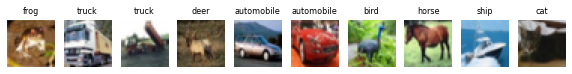

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i]), plt.axis('off')
    plt.title(class_names[y_train[i,0]], fontsize=8)
plt.show()

In [8]:
# # X_data : 0~1 사이의 실수 (float32) 로 변환
# X_train = X_train/255.0
# X_test  = X_test/255.0

In [9]:
# X_data : 0~1 사이의 실수 (float32) 로 변환
X_train = X_train.astype('float32') / 255.
X_test  = X_test.astype(np.float32) / 255.  # np.float32 의미 모르겠다.

In [10]:
# y_data : One-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

## 모델 정의 / 설정 / 학습 / 평가

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    # 패딩층이 왜이리 많아?

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [13]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(
    optimizer = opt,
    loss= 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
import os
if not os.path.exists('model'):
    os.mkdir('model')
checkpointer = ModelCheckpoint(
    MODEL_PATH, verbose=1, save_best_ony = True
)
early_stopping = EarlyStopping(patience=10)

In [20]:
# 데이터 부풀리기

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,        # apply ZCA whitening
    zca_epsilon=1e-06,          # epsilon for ZCA whitening
    rotation_range=0,           # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,      # randomly shift images horizontally
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.,             # set range for random shear
    zoom_range=0.,              # set range for random zoom
    channel_shift_range=0.,     # set range for random channel shifts
    fill_mode='nearest',        # set mode for filling points outside the input boundaries
    cval=0.,                    # value used for fill_mode = "constant"
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    rescale=None,               # set rescaling factor (applied before any other transformation)
    preprocessing_function=None, # set function that will be applied on each input
    data_format=None,           # image data format, either "channels_first" or "channels_last"
    validation_split=0.0        # fraction of images reserved for validation
)
datagen.fit(X_train)

# cifar 10 처럼 데이터가 많은 경우 (5만 , 1만) 데이터 부풀리기는 하지 않아도 좋다.
다만 데이터가 적은 경우에는 매우 효과적이다. 

In [23]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, verbose = 2,
    # shuffle=True,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/100

Epoch 00001: saving model to model/best_cifar-10.h5
1000/1000 - 27s - loss: 1.9187 - accuracy: 0.2902 - val_loss: 1.6273 - val_accuracy: 0.4155 - 27s/epoch - 27ms/step
Epoch 2/100

Epoch 00002: saving model to model/best_cifar-10.h5
1000/1000 - 16s - loss: 1.6496 - accuracy: 0.3938 - val_loss: 1.4838 - val_accuracy: 0.4566 - 16s/epoch - 16ms/step
Epoch 3/100

Epoch 00003: saving model to model/best_cifar-10.h5
1000/1000 - 16s - loss: 1.5435 - accuracy: 0.4338 - val_loss: 1.4056 - val_accuracy: 0.4908 - 16s/epoch - 16ms/step
Epoch 4/100

Epoch 00004: saving model to model/best_cifar-10.h5
1000/1000 - 16s - loss: 1.4630 - accuracy: 0.4655 - val_loss: 1.3444 - val_accuracy: 0.5063 - 16s/epoch - 16ms/step
Epoch 5/100

Epoch 00005: saving model to model/best_cifar-10.h5
1000/1000 - 16s - loss: 1.4022 - accuracy: 0.4950 - val_loss: 1.3031 - val_accuracy: 0.5299 - 16s/epoch - 16ms/step
Epoch 6/100

Epoch 00006: saving model to model/best_cifar-10.h5
1000/1000 - 16s - loss: 1.3564

In [27]:
best_model = load_model(MODEL_PATH)
best_model.evaluate(X_test,Y_test)
# 313/313 [==============================] - 1s 4ms/step - loss: 0.6715 - accuracy: 0.7818 원래 데이터  이건 샘과 같다. 
# [0.6714779734611511, 0.7817999720573425]
# 313/313 [==============================] - 2s 6ms/step - loss: 0.6716 - accuracy: 0.7845  
# [0.6715840101242065, 0.784500002861023] 다시돌린 데이터 ? 왜 다르지 아! 플로트 설정

# 이번에는 셔플은 뺏지만.. 뭐가 크게 다르려나?
# 313/313 [==============================] - 1s 4ms/step - loss: 0.7681 - accuracy: 0.7385
# [0.7680691480636597, 0.7384999990463257]

313/313 [==============================] - 1s 4ms/step - loss: 0.7681 - accuracy: 0.7385


[0.7680691480636597, 0.7384999990463257]

- 학습과정 시각화

In [25]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

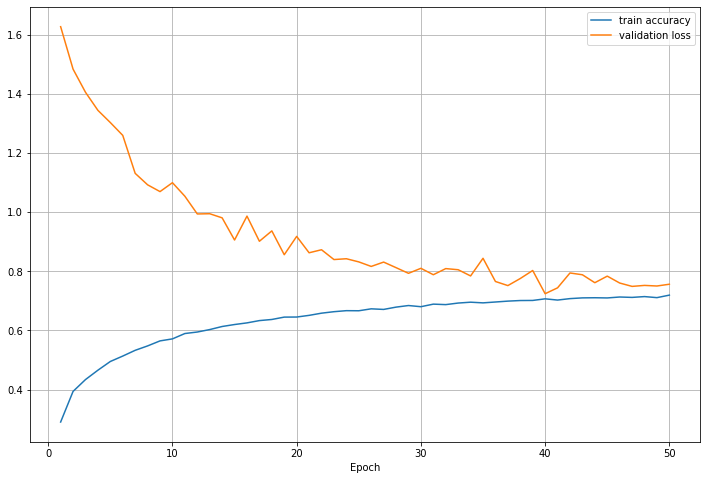

In [26]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

In [28]:
# 남은시간동안에 우리 뭘 한번 해볼까요?